## A.3: Final Report: SOTU

### Load Libraries

In [1]:
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# import nltk.download
# from nltk.download import stopwords

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ksenialuu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Functionality to turn stemming on or off
STEMMING = False
NGRAM_LENGTH = 2

#### Pandas Parameters

In [3]:
#pandas parameters
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Function to process documents

In [4]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    new_stopwords = ['years','great','tonight','congress','freedom','united','states','united states','americans','america','american','americas','government','people','world','shall','would','nations','national','nation'] #remove repeating terms
    stop_words = stop_words.union(new_stopwords)
    tokens = [w for w in tokens if not w in stop_words]        
    # word stemming    
    #if STEMMING:
        #ps=PorterStemmer()
        #tokens=[ps.stem(word) for word in tokens]
    return tokens

###   Functions to label encoding

In [5]:
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE

In [7]:
# read data
data = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/sotu_corpus_small.csv?token=AMCK53AB3UCXN3Z6C7GYVHC6KSN2A")


In [8]:
# new data frame with split value columns 
new = data["DSI_Title"].str.split("_", n = 1, expand = True) 
  
# making separate President_Name column from new data frame 
data["President_Name"] = new[0] 
  
# making separate Year_SOTU column from new data frame 
data["Year_SOTU"] = new[1] 
  
new = data["Year_SOTU"].str.split(".", n = 1, expand = True) 
data["Year_SOTU"] = new[0] 

# df display 
data.head(5) 

,Unnamed: 0,DSI_Title,Text,President_Name,Year_SOTU
0,0,Reagan_1982.txt,"Mr. Speaker, Mr. President, distinguished Memb...",Reagan,1982
1,1,Wilson_1914.txt,GENTLEMEN OF THE CONGRESS: The session upon w...,Wilson,1914
2,2,Madison_1814.txt,Fellow-Citizens of the Senate and House of Rep...,Madison,1814
3,3,Johnson_1969.txt,"Mr. Speaker, Mr. President, Members of the Con...",Johnson,1969
4,4,Hoover_1930.txt,To the Senate and House of Representatives: I...,Hoover,1930


### Processing text into lists

In [9]:
# create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)

# create empty list to store text documents
text_body=[]

# for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

# Note: the text_body is the unprocessed list of documents read directly form the csv.

# empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

# stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)

### Sklearn TFIDF 
note the ngram_range will allow you to include multiple words within the TFIDF matrix

In [10]:
# Call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,2))

#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.
TFIDF_matrix=Tfidf.fit_transform(final_processed_text)

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

In [11]:
# Verify TFIDF_Matrix has been created.

matrix.head()

,aaron,aaron associates,abandon,abandon blessings,abandon cause,abandon conquest,abandon desire,abandon domination,abandon fault,abandon growth,abandon ideals,abandon iraqi,abandon iraqis,abandon measures,abandon nuclear,abandon philosophy,abandon practices,abandon pursuit,abandon rapacity,abandon reasonable,abandon responsibilities,abandon slightest,abandon splendid,abandon struggle,abandoned,abandoned boats,abandoned conclusion,abandoned corners,abandoned doorwayson,abandoned errors,abandoned hazardous,abandoned increased,abandoned problems,abandoned recourse,abandoned relieve,abandoned security,abandoned superpowers,abandoned trickledown,abandoning,abandoning bipartisan,abandoning commitments,abandoning every,abandoning overlooking,abandoning south,abandonment,abandonment horrible,abandonment mentally,abandonment protective,abatement,abatement exactions,abatement satisfaction,abbas,abbas discuss,abbreviation,abbreviation subject,abdicated,abdicated abdicated,abdicated passing,abdication,abdication federal,abdication restoration,abduction,abduction intensify,abetted,abetted tumults,abettors,abettors faith,abhor,abhor methods,abhorrent,abhorrent never,abide,abide confined,abide minister,abide rivalries,abide within,abiding,abiding conviction,abiding friendship,abiding interests,abiding logic,abiding strength,abilities,abilities gifts,abilities skills,abilities tried,abilities unite,ability,ability achieve,ability acting,ability adjust,ability analyze,ability better,ability capacity,ability collect,ability command,ability compete,ability complainants,ability constantly,ability contrary,ability contribute,ability decisions,ability defend,ability deter,ability discharged,ability establish,ability everywhere,ability execute,ability expand,ability fliers,ability govern,ability imagination,ability improve,ability indefatigable,ability insist,ability inspire,ability knowhow,ability monitor,ability negotiate,ability others,ability overcome,ability patriotism,ability powers,ability preserve,ability president,ability presidents,ability produce,ability programs,ability progress,ability remain,ability required,ability resist,ability served,ability services,ability successful,ability supply,ability support,ability sustain,ability taxes,ability things,ability together,ability unwearied,abject,abject farmers,abject poverty,ablaze,ablaze continent,ablebodied,ablebodied adult,ablebodied census,ablebodied destitute,ablebodied receive,ablebodied women,ablest,ablest professors,abnormal,abnormal conditions,aboard,aboard aircraft,aboard first,abolish,abolish heroes,abolish racial,abolish trading,abolish within,abolished,abolished competition,abolished hunger,abolished legislature,abolished uniform,abolishes,abolishes tribute,abolishing,abolishing almost,abolishing present,abolishing system,abolition,abolition absence,abolition discriminating,abolition duties,abolition features,abolition oppresses,abolition slavery,abominable,abominable wrong,abortion,abortion children,abortion demand,abortion economic,abortion either,abortion grips,abortion human,abortion others,abortions,abortions point,abounds,abounds among,abounds animating,aboutall,aboutall democrats,aboutlabor,aboutlabor business,aboutmeasures,aboutmeasures advance,abraham,abraham lincoln,abraham lincolnslet,abraham senior,abreast,abreast realistic,abridge,abridge evils,abridged,abridged means,abridged returning,abridged unequal,abridges,abridges rights,abroad,abroad advance,abroad affected,abroad aftermath,abroad among,abroad around,abroad arrived,abroad asking,abroad believe,abroad butter,abroad challenge,abroad chance,abroad civil,abroad committed,abroad common,abroad community,abroad confidence,abroad conformity,abroad continued,abroad cooperation,abroad countervailing,abroad create,abroad directly,abroad donethe,abroad efficacy,abroad especially,abroad essential,abroad establishment,abroad expenditures,abroad eyeandahalf,abroad failed,abroad friends,...,yesterday member,yesterday today,y

In [12]:
# Get unique names of President_Name to ensure BushW and BusHW were enetered correctly.
data['President_Name'].unique()

array(['Reagan', 'Wilson', 'Madison', 'Johnson', 'Hoover', 'Roosevelt',
       'Truman', 'Kennedy', 'Jefferson', 'Monroe', 'Trump', 'Eisenhower',
       'Obama', 'Adams', 'BushHW', 'Cleveland', 'Grant', 'Washington',
       'Ford', 'BushW', 'Nixon', 'Carter', 'Arthur'], dtype=object)

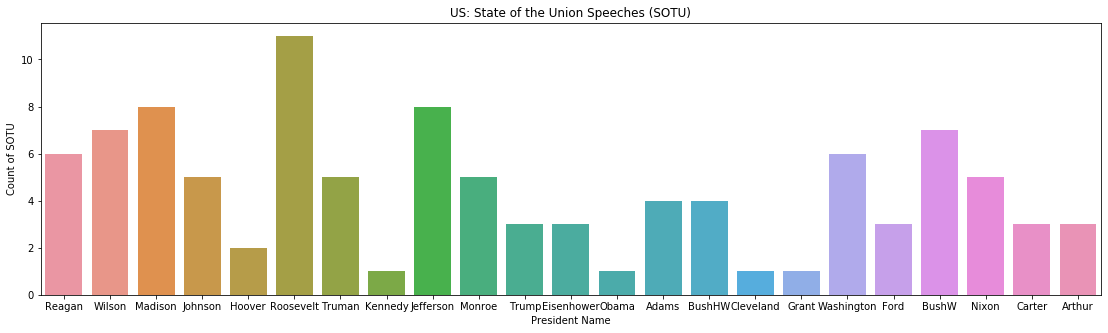

In [13]:
# Simple plot to show the number of SOTU speeches by President Name

import seaborn as sns

plt.subplots(figsize=(19,5))
ax = sns.countplot(x="President_Name", data=data)
# plt.savefig("plot-president_name.pdf", bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', orientation='portrait', papertype=None, format=None, pad_inches=0.25)
plt.xlabel('President Name')
plt.ylabel('Count of SOTU')
plt.title('US: State of the Union Speeches (SOTU)')
plt.show()

### Explore TFIDF Values

In [14]:
average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])

average_TFIDF_DF=pd.DataFrame(average_TFIDF,index=[0]).transpose()

average_TFIDF_DF.columns=['TFIDF']

#calculate Q1 and Q3 range
Q1=np.percentile(average_TFIDF_DF, 25)
Q3=np.percentile(average_TFIDF_DF, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)

#words that exceed the Q3+IQR*1.5
outlier_list=average_TFIDF_DF[average_TFIDF_DF['TFIDF']>=outlier]

### Doc2Vec

In [15]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)

### Gensim Word2vec 
Note, there are opportunities to use the word2vec matrix to determine words which are similar.  Similar words can be used to create equivalent classes.  
k-means is not used to group individual words using the Word2Vec output.

In [16]:
#word to vec
model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)

#obtian all the unique words from DSI
w2v_words=list(set(processed_text_w2v))

#can also use the get_feature_names() from TFIDF to get the list of words
#w2v_words=Tfidf.get_feature_names()

#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()

### K Means Clustering - TFIDF
the following section runs applies the k-means algorithm on the TFIDF matrix.

In [17]:
k=6
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])


print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

Top terms per cluster:
Cluster 0:
 treaty
 spain
 friendly
 country
 convention
 citizens
 subject
 relations
 intercourse
 territory
 majesty
 minister
 powers
 spanish
 chile
Cluster 0 titles: Adams_1799.txt, Monroe_1819.txt, Grant_1872.txt, Monroe_1818.txt, Jefferson_1804.txt, Arthur_1883.txt, Jefferson_1803.txt, Arthur_1882.txt, Arthur_1881.txt,Cluster 1:
 terrorists
 country
 security
 terror
 children
 health
 iraqi
 workers
 every
 economy
 weapons
 terrorist
 fight
 women
 social security
Cluster 1 titles: Trump_2017.txt, Obama_2016.txt, Roosevelt_1942.txt, Trump_2019.txt, Trump_2018.txt, BushW_2005.txt, BushW_2004.txt, BushW_2006.txt, BushW_2007.txt, BushW_2003.txt, BushW_2002.txt, BushW_2001.txt,Cluster 2:
 federal
 peace
 budget
 programs
 soviet
 billion
 economic
 program
 growth
 today
 defense
 every
 president
 future
 spending
Cluster 2 titles: Reagan_1982.txt, Johnson_1969.txt, Johnson_1968.txt, Reagan_1984.txt, Reagan_1985.txt, Reagan_1987.txt, Kennedy_1963.txt, Reag

### Plotting 
Convert two components as we're plotting points in a two-dimensional plane
"precomputed" because we provide a distance matrix

We will also specify `random_state` so the plot is reproducible.

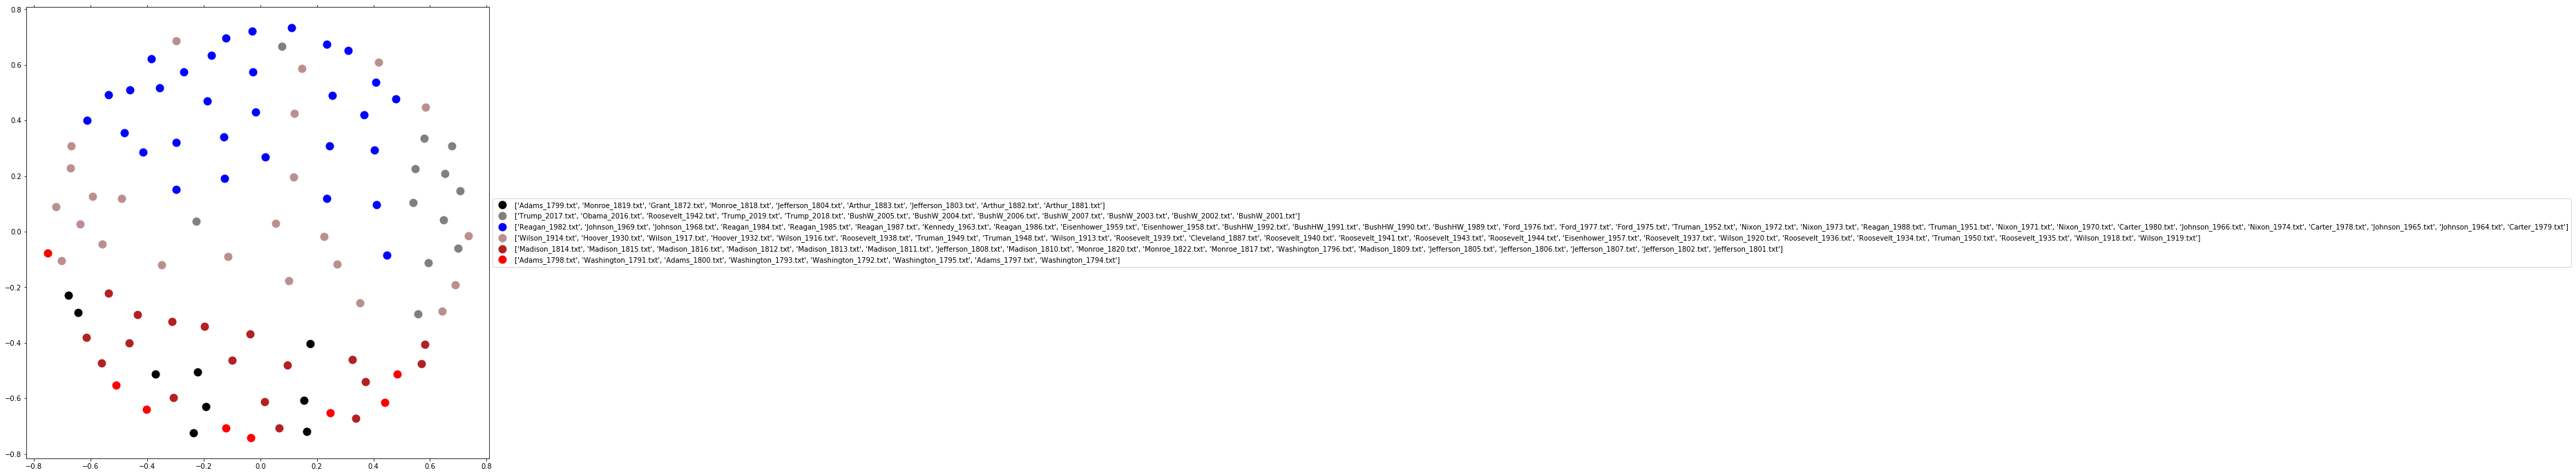

In [18]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(TFIDF_matrix)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 5:'red', 6:'darksalmon', 7:'sienna', 8:'green', 9:'purple', 10:'pink', 11:'yellow'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

### Review Clusters

In [19]:
term_clusters = pd.DataFrame.from_dict(cluster_terms) #pull out terms into a dataframe
terms = term_clusters.stack() #stack terms names into 1 column
terms = terms.reset_index() #move index into a column
terms = terms.rename(columns={'level_1': 'cluster_term', 0:'term'}) #rename columns
terms = terms.drop(['level_0'], axis=1) #drop unecessary column
terms.head()

,cluster_term,term
0,0,treaty
1,1,terrorists
2,2,federal
3,3,economic
4,4,british


In [20]:
# look at frequent terms across clusters
term_clusters

,0,1,2,3,4,5
0,treaty,terrorists,federal,economic,british,gentlemen
1,spain,country,peace,peace,public,public
2,friendly,security,budget,country,commerce,commissioners
3,country,terror,programs,labor,vessels,indians
4,convention,children,soviet,every,millions,treaty
5,citizens,health,billion,business,militia,gentlemen house
6,subject,iraqi,economic,industrial,treasury,commerce
7,relations,workers,program,production,subject,measures
8,intercourse,every,growth,present,enemy,house representatives
9,territory,economy,today,democracy,country,gentlemen senate


In [21]:
titles = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
titles = titles.stack() #stack document names into 1 column
titles = titles.reset_index() #move index into a column
titles = titles.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
titles = titles.drop(['level_1'], axis=1) #drop unecessary column
titles.head()

,cluster_doc,document
0,0,Adams_1799.txt
1,0,Monroe_1819.txt
2,0,Grant_1872.txt
3,0,Monroe_1818.txt
4,0,Jefferson_1804.txt


In [22]:
# join TFIDF values to documents in new dataframe w/ clusters
term_list = terms['term'].values.tolist() #pull all terms into a list
matrix_clustering = matrix[term_list] #pull out only terms in clusters
full_titles = titles.set_index('document').join(matrix_clustering, how='left') # join in tf-idf values
full_titles.shape

(102, 91)

In [23]:
# calculate average tf-idf values for each cluster of terms
for i in range (k):
    full_titles[i] = full_titles[term_clusters[i].values.tolist()].mean(axis=1)

In [24]:
# remove all other columsn leaving only the average 
full_titles = full_titles.set_index('cluster_doc', append=True)
full_titles_final = full_titles[full_titles.columns[-k:]]

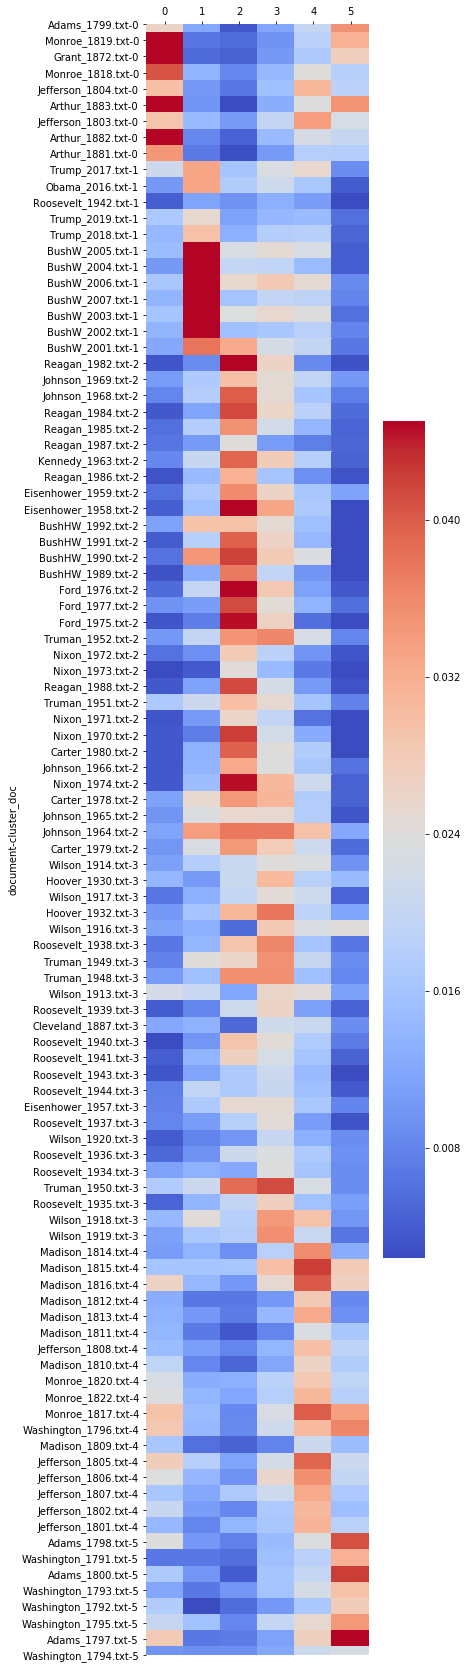

In [25]:
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(5,30))
plt.rcParams['font.size'] = 10
p=sns.heatmap(full_titles_final, cmap='coolwarm', robust=True)
p.xaxis.tick_top()
p.xaxis.set_label_position('top')

In [26]:
p.get_figure().savefig('heatmap_6.png')

# heatmap_1 using 8 clusters, no additional stopwords removed
# heatmap_2 using 8 clusters, reduced term size to 1-2 words, removed frequent words
# heatmap_3 using 6 clusters, reduced term size to 1-2 words, removed frequent words
# heatmap_4 using 6 clusters, reduced term size to 1-3 words, removed frequent words
# heatmap_5 using 6 clusters, reduced term size to 1-2 words, removed frequent words, increased top term size to 15 *BEST*
# heatmap_6 using 6 clsuters, reduced term size to 1-2 words, removed frequent words, increased top term size to 20

##### Look at terms that show up in all documents

In [46]:
matrix_copy = matrix.copy() #copy dataframe
matrix_copy = matrix_copy.T  #transpose

matrix_copy[(matrix_copy != 0).all(1)] # pull terms that show up in all documents


,Reagan_1982.txt,Wilson_1914.txt,Madison_1814.txt,Johnson_1969.txt,Hoover_1930.txt,Johnson_1968.txt,Madison_1815.txt,Wilson_1917.txt,Hoover_1932.txt,Madison_1816.txt,Wilson_1916.txt,Reagan_1984.txt,Roosevelt_1938.txt,Madison_1812.txt,Truman_1949.txt,Truman_1948.txt,Madison_1813.txt,Wilson_1913.txt,Roosevelt_1939.txt,Reagan_1985.txt,Reagan_1987.txt,Madison_1811.txt,Kennedy_1963.txt,Jefferson_1808.txt,Madison_1810.txt,Reagan_1986.txt,Monroe_1820.txt,Trump_2017.txt,Eisenhower_1959.txt,Obama_2016.txt,Adams_1799.txt,Adams_1798.txt,Eisenhower_1958.txt,Monroe_1822.txt,BushHW_1992.txt,Monroe_1819.txt,Cleveland_1887.txt,BushHW_1991.txt,BushHW_1990.txt,Grant_1872.txt,Monroe_1818.txt,Roosevelt_1940.txt,BushHW_1989.txt,Washington_1791.txt,Roosevelt_1941.txt,Adams_1800.txt,Roosevelt_1943.txt,Washington_1793.txt,Washington_1792.txt,Roosevelt_1942.txt,Monroe_1817.txt,Ford_1976.txt,Washington_1796.txt,Trump_2019.txt,Trump_2018.txt,Ford_1977.txt,Ford_1975.txt,Washington_1795.txt,Adams_1797.txt,Washington_1794.txt,Roosevelt_1944.txt,Eisenhower_1957.txt,BushW_2005.txt,Roosevelt_1937.txt,Madison_1809.txt,Truman_1952.txt,Jefferson_1805.txt,Nixon_1972.txt,Nixon_1973.txt,Jefferson_1804.txt,Wilson_1920.txt,Roosevelt_1936.txt,BushW_2004.txt,Reagan_1988.txt,Roosevelt_1934.txt,BushW_2006.txt,Truman_1951.txt,Jefferson_1806.txt,Nixon_1971.txt,Nixon_1970.txt,Jefferson_1807.txt,Truman_1950.txt,BushW_2007.txt,Roosevelt_1935.txt,Carter_1980.txt,BushW_2003.txt,Arthur_1883.txt,Jefferson_1803.txt,Johnson_1966.txt,Nixon_1974.txt,Jefferson_1802.txt,Arthur_1882.txt,BushW_2002.txt,Carter_1978.txt,Wilson_1918.txt,Johnson_1965.txt,Johnson_1964.txt,Jefferson_1801.txt,Arthur_1881.txt,Wilson_1919.txt,Carter_1979.txt,BushW_2001.txt
congress,0.034904,0.022359,0.013204,0.095151,0.057499,0.083591,0.042682,0.02692,0.054281,0.038682,0.042890,0.016559,0.030962,0.007143,0.057530,0.041085,0.010457,0.032021,0.037862,0.018168,0.079849,0.025309,0.015940,0.028052,0.041064,0.020194,0.034983,0.021890,0.041247,0.013464,0.020995,0.004312,0.026323,0.043546,0.042780,0.024674,0.020149,0.012948,0.0134,0.046023,0.037600,0.021962,0.029598,0.004293,0.035589,0.034124,0.014838,0.032855,0.009134,0.006832,0.054104,0.038560,0.011297,0.036237,0.034751,0.057924,0.062709,0.022949,0.013159,0.026458,0.042925,0.053544,0.040065,0.037681,0.014812,0.042265,0.030916,0.077246,0.04084,0.009337,0.055759,0.049220,0.031744,0.033813,0.025955,0.031347,0.031769,0.015355,0.102106,0.052592,0.016978,0.055476,0.031540,0.026106,0.019759,0.024008,0.030483,0.056426,0.021377,0.057733,0.013359,0.043083,0.027668,0.021389,0.025450,0.021476,0.033313,0.010939,0.042930,0.048376,0.0345,0.017766
states,0.024164,0.047911,0.017605,0.026249,0.027381,0.014412,0.039125,0.01346,0.014285,0.052748,0.004289,0.016559,0.028147,0.028570,0.023689,0.035607,0.062744,0.032021,0.009466,0.015140,0.029943,0.059055,0.013283,0.040074,0.049276,0.006731,0.055973,0.032835,0.013749,0.016157,0.052487,0.064676,0.010529,0.072577,0.015278,0.087731,0.002519,0.035606,0.0067,0.092047,0.072308,0.040264,0.002960,0.077279,0.021353,0.039811,0.008903,0.112646,0.022836,0.017079,0.078151,0.033052,0.060253,0.054356,0.016039,0.031858,0.020903,0.022949,0.078956,0.071814,0.006604,0.029747,0.013355,0.022609,0.049373,0.011271,0.007729,0.013434,0.01021,0.009337,0.031862,0.045939,0.018517,0.019724,0.008652,0.020898,0.012708,0.042225,0.057059,0.015468,0.025467,0.016643,0.028912,0.016316,0.046105,0.021607,0.057918,0.030383,0.016033,0.046186,0.008906,0.050264,0.027668,0.024445,0.002828,0.015340,0.007403,0.029170,0.070528,0.017074,0.0138,0.008883


### K Means Clustering Doc2Vec
The following section of code is to run the k-means algorithm on the doc2vec outputs.

Note the differences in document clusters compared to the TFIDF matrix.

In [26]:
doc2vec_k_means=doc2vec_df.drop('title', axis=1)

k=8
km = KMeans(n_clusters=k, random_state =89)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

#dictionary to store clusters and respective titles
cluster_title={}

#note doc2vec clusters will not have individual words due to the vector representation
#is based on the entire document not indvidual words. As a result, there won't be individual
#word outputs from each cluster.   
for i in range(k):
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for title in temp['Doc Name']:
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list

### Plotting Doc2vec
Convert two components as we're plotting points in a two-dimensional plane "precomputed" because we provide a distance matrix

We will also specify `random_state` so the plot is reproducible.

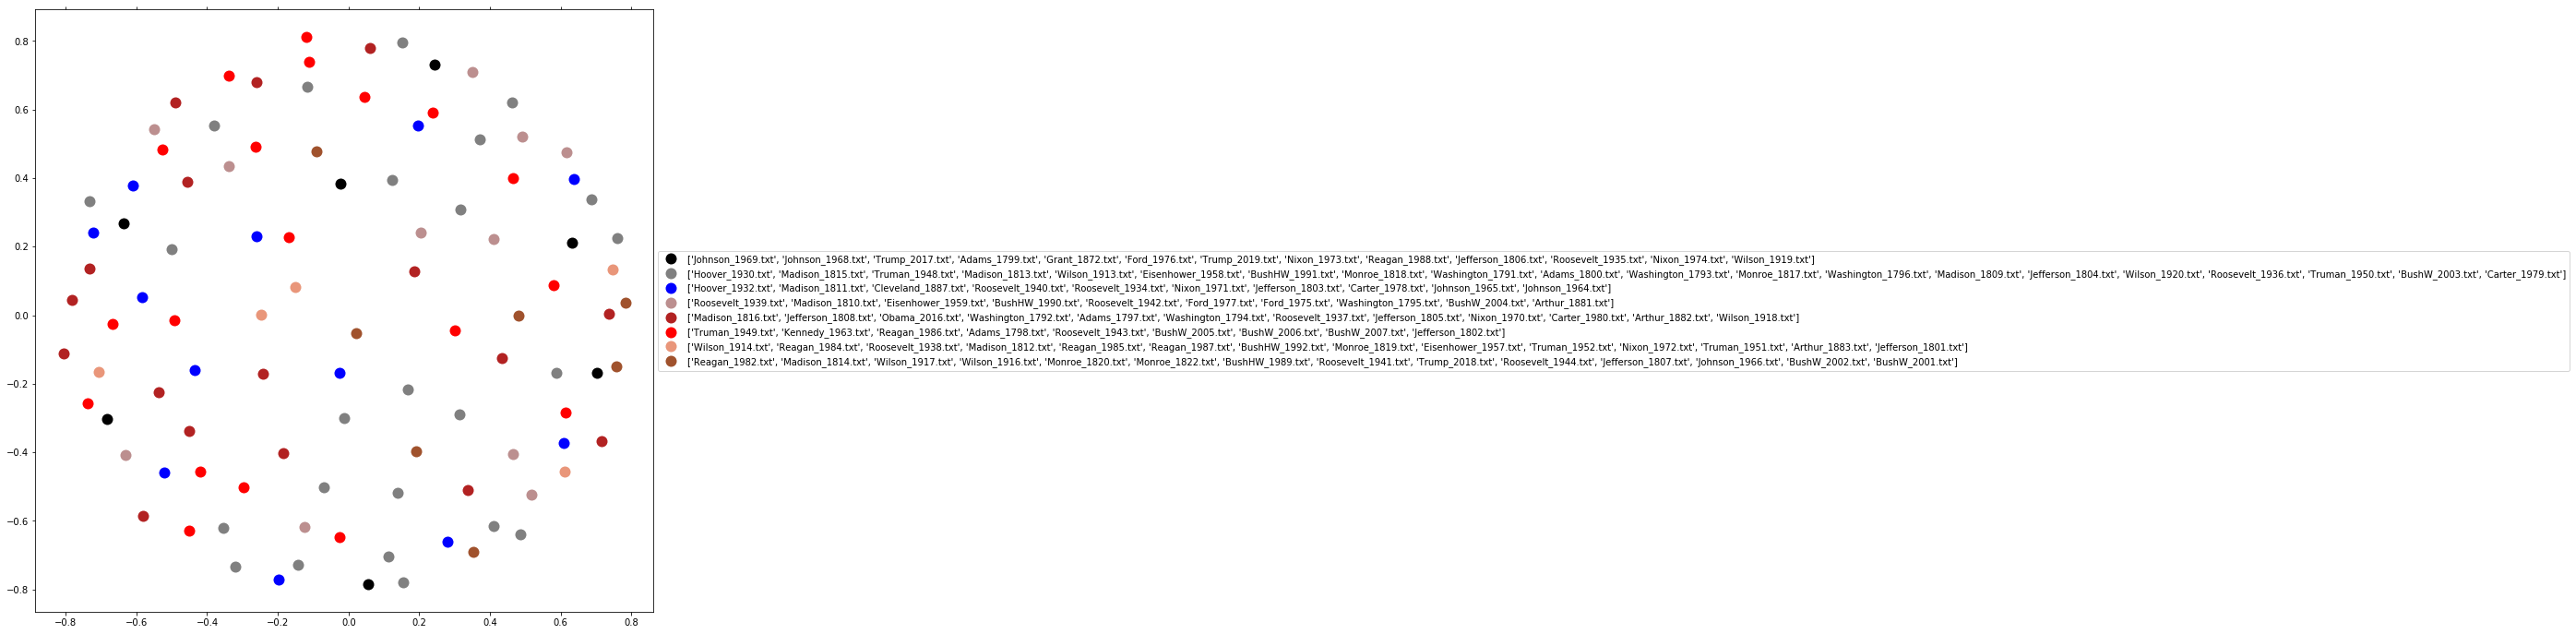

In [27]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(doc2vec_k_means)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 5:'red', 6:'darksalmon', 7:'sienna', 8:'green', 9:'purple', 10:'pink', 11:'yellow'}


#set up cluster names using a dict.  
cluster_dict=cluster_title         

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

In [40]:
# Creating dataframe from CV Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=(1,3))
cv_matrix=cv.fit_transform(final_processed_text)    
cv_matrix=pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names(), index=titles)   

### Classification using various RF Model

The following section is used to create a model to predict the clusters labels based on the the TFIDF matrix and the doc2vec vectors.  

Note the model performance using the two different vectorization methods.

In [28]:
model_RF=RandomForestClassifier()

#TFIDF
Y=clusters
X=TFIDF_matrix

#cross validation
cv_score=cross_val_score(model_RF, X,Y, cv=5)

#mean CV score
np.mean(cv_score)

#Doc2Vec
Y=clusters_d2v
X=doc2vec_k_means

#cross validation
cv_score=cross_val_score(model_RF, X, Y, cv=5)

#mean CV score
np.mean(cv_score)

/Users/ksenialuu/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ksenialuu/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ksenialuu/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/ksenialuu/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kseni

0.2137789661319073

In [62]:
# Trying few things out (Ali)

# Create transposed dataframe from CV Matrix
matrix_corp_t = matrix.transpose()
cv_matrix_corp_t = cv_matrix.transpose() 

# Sum all the terms to create Term Frequency and Document Frequency for each term
cv_matrix_corp_t['df_corpus']= (cv_matrix_corp_t != 0).sum(axis=1)
cv_matrix_corp_t['tf_corpus']= cv_matrix_corp_t.sum(axis=1) - cv_matrix_corp_t['df_corpus']

# Remove uncessary columns from the dataframe after summing them
idx = np.r_[0:102]
cv_matrix_corp_t.drop(cv_matrix_corp_t.columns[idx], axis=1, inplace=True)

print("Top 10 Terms based on document frequency.")
print(cv_matrix_corp_t[['df_corpus']].nlargest(10, 'df_corpus'))
print("\n")
print("Top 10 Terms based on frequency.")
print(cv_matrix_corp_t[['tf_corpus']].nlargest(10, 'tf_corpus'))

Top 10 Terms based on document frequency.
               df_corpus
congress             102
states               102
government           101
united               101
country              100
nation               100
would                100
every                 99
great                 99
united states         99


Top 10 Terms based on frequency.
               tf_corpus
government          1152
people              1082
congress            1072
world               1059
states               954
united               866
great                783
american             751
united states        748
america              726
